### Salary prediction, episode II: make it actually work (4 points)

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__. Try __at least 3 options__ from the list below for a passing grade. Write a short report about what you have tried. More ideas = more bonus points. 

__Please be serious:__ " plot learning curves in MAE/epoch, compare models based on optimal performance, test one change at a time. You know the drill :)

You can use either __pytorch__ or __tensorflow__ or any other framework (e.g. pure __keras__). Feel free to adapt the seminar code for your needs. For tensorflow version, consider `seminar_tf2.ipynb` as a starting point.


In [21]:
import torch
from torch import nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Prepare dataset

In [7]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data.shape

(244768, 12)

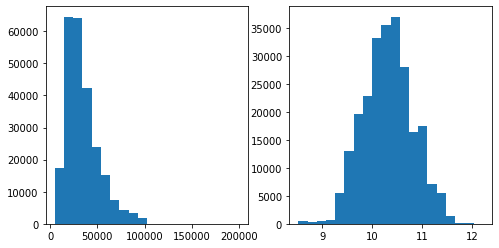

In [8]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

In [9]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
137524,70410846,Banking Advisor,When people pay a visit to their local Halifax...,Radstock,Radstock,full_time,NaN,NaN,Customer Services Jobs,"17,478.00 - 19,420.00 per year",18449,Jobcentre Plus,9.822820
67657,68724896,Senior HR Advisor,Our client is seeking an experienced HR profes...,"Manchester, England, Greater Manchester",Manchester,NaN,NaN,Hudson,HR & Recruitment Jobs,30000 - 35000 per annum,32500,Personneltoday Jobs,10.389026
7582,64796836,"Technical Tester Manual, Automation, Java, SQ...","Technical Tester Manual, Automation, Java, SQ...",London,London,NaN,permanent,NaN,IT Jobs,4000 - 35000 per annum + Benefits,19500,theitjobboard.co.uk,9.878221


In [10]:
import nltk
#TODO YOUR CODE HERE

tokenizer = nltk.tokenize.WordPunctTokenizer()
data["FullDescription"] = data["FullDescription"].apply(lambda x: " ".join(tokenizer.tokenize(x.lower())))
data["Title"] = data["Title"].apply(lambda x: " ".join(tokenizer.tokenize(str(x).lower())))
# YOUR CODE HERE

In [11]:
from collections import Counter
token_counts = Counter()

for row in data.FullDescription.values:
    token_counts.update(row.split())

for row in data.Title.values:
    token_counts.update(row.split())
# Count how many times does each token occur in both "Title" and "FullDescription" in total
#TODO <YOUR CODE>

In [12]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = sorted(t for t, c in token_counts.items() if c >= min_count)#TODO<YOUR CODE HERE>

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [13]:
token_to_id = {tok: i for i, tok in enumerate(tokens)}
#<your code here - dict of token name to its index in tokens>

In [14]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [15]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

In [16]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [18]:
target_column = "Log1pSalary"

In [19]:
import torch

def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors

def make_batch(data, max_len=None, word_dropout=0, device=torch.device('cpu')):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if TARGET_COLUMN in data.columns:
        batch[target_column] = data[TARGET_COLUMN].values
    
    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [20]:
make_batch(data_train[:3], max_len=10)

{'Title': tensor([[27645, 29893, 33674,     1,     1,     1,     1],
         [29239,   197, 19175, 20042, 15554, 23162,  4051],
         [10609, 30412, 17746,    33,  8705, 29157,    65]]),
 'FullDescription': tensor([[27645, 29893, 33674, 32939,   982, 27645, 29893, 33674, 16451, 32939],
         [29239,   197, 19175, 20042, 15554, 23162,  4051, 25511,   907,    82],
         [30746, 21956, 20601,  6409, 16451,  8165, 27493,   982, 30412, 17746]]),
 'Categorical': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'Log1pSalary': tensor([ 9.7115, 10.4631, 10.7144])}

### Models

*A)* CNN block : conv -> BN -> relu -> conv -> BN

In [52]:
def create_block(in_channels, out_channels):
        return nn.Sequential(
            [
                nn.Conv1d(in_channels, out_channels, 5),
                nn.BatchNorm1d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv1d(out_channels, out_channels, 5),
                nn.BatchNorm1d(out_channels)
            ]
        )

In [361]:
class SalaryPredictiorCNN(nn.Module):
    def __init__(self, n_toks=len(tokens), hidden_layers = [1, 2, 4, 4, 8], emb_size=64, n_parallel_layers = 1):
        super().__init__()
        
        self.embs = nn.Embedding(n_toks, emb_size)
        
        self.cnn_blocks = []
        self.n_parallel_layers = n_parallel_layers
        for in_ch, out_ch in zip(hidden_layers[:-1], hidden_layers[1:]):
#             print(in_ch, out_ch)
            self.cnn_blocks.append([self.__create_block(in_ch, out_ch)] * self.n_parallel_layers)
        
        last_layer = self.cnn_blocks[-1][0][-2]
        last_size = last_layer.in_channels - last_layer.kernel_size[0] + 2 * last_layer.padding[0]
        last_size /= last_layer.stride[0] + 1
#         print(last_size)
#         self.final = nn.Linear(hidden_layers[-1] * self.n_parallel_layers, 1)
#         self.final = nn.Linear(last_size * self.n_parallel_layers, 1)
        self.flatten = nn.Flatten()
        self.final = nn.Linear(1024* 8, 1)
    
    
    def __create_block(self, in_channels, out_channels):
        return nn.Sequential(
                nn.Conv1d(in_channels, out_channels, 3, padding=1),
                nn.BatchNorm1d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv1d(out_channels, out_channels, 3, padding=1),
                nn.BatchNorm1d(out_channels)
        )
    
    
    def forward(self, x):
        res = self.embs(x["Title"])
#         print(res.shape)
        res = res.mean(axis=1).unsqueeze(1)
#         print(res.shape)
#         print('-' * 10)
        for layer in self.cnn_blocks:
#             print(layer)
#             print(res.shape)
#             print('-' * 10)
            res = torch.cat([l(res) for l in layer], dim=2)
#         print(res.shape)
        res = self.flatten(res)
#         print(res.shape)
        res = self.final(res).squeeze(1)
        return res + 1e-9

In [362]:
model = SalaryPredictiorCNN(n_parallel_layers=2)

In [363]:
model.eval()

SalaryPredictiorCNN(
  (embs): Embedding(34158, 64)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (final): Linear(in_features=8192, out_features=1, bias=True)
)

In [364]:
make_batch(data_train[:40])["Title"].shape

torch.Size([40, 17])

In [365]:
ans = model(make_batch(data_train[:40]))

In [366]:
64*2*2*2*2

1024

In [367]:
ans

tensor([ 8.5449e-02,  6.4177e-01,  4.0757e-01,  7.6553e-01, -1.9741e-02,
         1.9736e-01, -1.4268e-01,  2.6178e-01,  3.2774e-01, -3.0893e-01,
         4.9497e-01, -1.7877e-01,  7.8813e-02,  5.6077e-01,  7.9420e-02,
         5.9780e-02,  5.7616e-01,  8.8430e-02,  3.8331e-02, -1.6843e-01,
        -3.8935e-01,  3.9664e-01, -4.5666e-04,  1.7635e-01,  6.0994e-01,
        -3.5773e-01,  1.0374e-01, -2.8704e-01, -1.9245e-02, -3.3209e-01,
        -1.7349e-01,  3.3587e-01,  9.3969e-02, -6.6110e-03, -2.5908e-01,
         7.7325e-03,  1.5470e-01, -1.9888e-01,  2.8759e-01, -2.0808e-01],
       grad_fn=<AddBackward0>)

In [368]:
ans.shape

torch.Size([40])

In [369]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=torch.device('cpu'), **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            yield batch
        
        if not cycle: break

In [376]:
import tqdm

BATCH_SIZE = 32
EPOCHS = 20
DEVICE = torch.device('cpu')

In [377]:
def print_metrics(model, data, batch_size=BATCH_SIZE, name="", **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw):
            batch_pred = model(batch)
            squared_error += torch.sum(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.sum(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch_pred)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return mse, mae

In [378]:
data[TARGET_COLUMN]

0         10.126671
1         10.308986
2         10.308986
3         10.221977
4         10.126671
            ...    
244763    10.034559
244764    10.034559
244765    10.034559
244766    10.034559
244767    10.657283
Name: Log1pSalary, Length: 244768, dtype: float32

In [381]:
%%time
model = SalaryPredictiorCNN(n_parallel_layers=2).to(DEVICE)
# criterion = nn.MSELoss(reduction='sum')
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model.train()
#     for i, batch in tqdm.tqdm_notebook(enumerate(
#             iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=DEVICE)),
#             total=len(data_train) // BATCH_SIZE
#         ):
    for i, batch in tqdm.tqdm(enumerate(iterate_minibatches(data_train, 
                                                            batch_size=BATCH_SIZE, device=DEVICE))):
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print_metrics(model, data_val)

epoch: 0


6120it [02:52, 35.42it/s]


 results:
Mean square error: 0.42460
Mean absolute error: 0.47051
epoch: 1


6120it [02:49, 36.05it/s]


 results:
Mean square error: 0.38537
Mean absolute error: 0.45784
epoch: 2


6120it [02:48, 36.43it/s]


 results:
Mean square error: 0.39435
Mean absolute error: 0.47914
epoch: 3


6120it [02:42, 37.61it/s]


 results:
Mean square error: 0.61676
Mean absolute error: 0.65078
epoch: 4


6120it [02:43, 37.40it/s]


 results:
Mean square error: 0.32267
Mean absolute error: 0.42713
epoch: 5


6120it [02:44, 37.29it/s]


 results:
Mean square error: 0.38380
Mean absolute error: 0.48919
epoch: 6


6120it [02:42, 37.67it/s]


 results:
Mean square error: 0.30137
Mean absolute error: 0.41405
epoch: 7


6120it [02:44, 37.25it/s]


 results:
Mean square error: 0.71006
Mean absolute error: 0.71737
epoch: 8


6120it [02:44, 37.27it/s]


 results:
Mean square error: 0.35420
Mean absolute error: 0.47164
epoch: 9


6120it [02:45, 36.97it/s]


 results:
Mean square error: 0.57569
Mean absolute error: 0.62372
epoch: 10


6120it [02:45, 37.05it/s]


 results:
Mean square error: 0.28709
Mean absolute error: 0.41321
epoch: 11


6120it [02:46, 36.78it/s]


 results:
Mean square error: 0.33690
Mean absolute error: 0.45229
epoch: 12


6120it [02:47, 36.45it/s]


 results:
Mean square error: 0.31754
Mean absolute error: 0.44440
epoch: 13


6120it [02:45, 36.89it/s]


 results:
Mean square error: 0.46384
Mean absolute error: 0.56203
epoch: 14


6120it [02:48, 36.37it/s]


 results:
Mean square error: 0.42632
Mean absolute error: 0.52231
epoch: 15


6120it [02:49, 36.06it/s]


 results:
Mean square error: 0.27432
Mean absolute error: 0.40696
epoch: 16


6120it [02:47, 36.56it/s]


 results:
Mean square error: 0.32802
Mean absolute error: 0.45735
epoch: 17


6120it [02:45, 36.98it/s]


 results:
Mean square error: 0.30467
Mean absolute error: 0.42828
epoch: 18


6120it [02:45, 37.04it/s]


 results:
Mean square error: 0.48622
Mean absolute error: 0.58032
epoch: 19


6120it [02:45, 36.87it/s]


 results:
Mean square error: 0.34995
Mean absolute error: 0.46611
CPU times: user 57min 14s, sys: 4min 1s, total: 1h 1min 16s
Wall time: 1h 1min 35s


In [384]:

# model()
make_batch(data_train[:40])

{'Title': tensor([[27645, 29893, 33674,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1],
         [29239,   197, 19175, 20042, 15554, 23162,  4051,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1],
         [10609, 30412, 17746,    33,  8705, 29157,    65,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1],
         [ 7574, 16690, 10804, 18371,   158,  3958,  8418,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1],
         [ 9895,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1],
         [32752,    82,  1814, 26345, 30479, 33840,    82,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1],
         [13278, 18864, 19446, 26167, 19037, 14137,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1],
         [2

In [391]:
dct_data = {"Title": ["middle data scientist"], 
            "FullDescription":[""], 
            'Category':[""], 'Company':[""], 'LocationNormalized':[""], 'ContractType':[""], 'ContractTime':[""]
}
np.exp(model(make_batch(pd.DataFrame(dct_data))).detach().numpy())

array([268.56677], dtype=float32)

In [385]:
data_train[:40]

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
0,69173058,senior support worker,senior support worker wanted a senior support ...,"Taunton, Somerset Somerset South West",Taunton,NaN,permanent,Other,Healthcare & Nursing Jobs,15931 - 17082 per annum,16506,totaljobs.com,9.711540
1,72450873,statistical / mathematical modeller in pharmac...,statistical / mathematical modeller in pharmac...,North West,North West London,NaN,permanent,Other,Scientific & QA Jobs,"From 30,000 to 40,000 per annum 30-40K",35000,totaljobs.com,10.463132
2,68364211,emc team leader ( def stan ),the opportunity my client is currently seeking...,Surrey,Surrey,NaN,permanent,Other,Engineering Jobs,45k + Bonus + Pension,45000,justengineers.net,10.714440
3,69556873,"core java engineer london , big data","core java engineer london , big data , mysql ,...",UK London,London,NaN,permanent,Engage PSG,IT Jobs,"55000 - 70000 per annum + Bens, Bonus (up to 2...",62500,careers4a.com,11.042938
4,71304393,driver,"**** driver reqd for busy parcel round , exper...",Brentwood,Brentwood,full_time,NaN,Other,Logistics & Warehouse Jobs,350.00 - 400.00 per week,18000,Jobcentre Plus,9.798182
5,69931550,vn **** ait rf technicians x ****,"vn **** ait rf technicians , based portsmouth ...",Hampshire,Hampshire,NaN,contract,Capital Strategy Associates,Other/General Jobs,19/hour,36480,cv-library.co.uk,10.504547
6,68233935,general manager mediterranean restaurant marke...,general manager mediterranean restaurant marke...,East Midlands,East Midlands,NaN,NaN,COREcruitment International,Hospitality & Catering Jobs,25000-27000 Per Annum,26000,caterer.com,10.165891
7,67443745,stock control opperative / van driver,stock control operative / van driver working w...,Manchester,Manchester,full_time,NaN,NaN,Logistics & Warehouse Jobs,6.46 - 12.39 per hour,18096,Jobcentre Plus,9.803501
8,71336165,"system tester linux , javascript , html , css ...",system tester with experience of linux and ( i...,Sussex Chichester PO188,Cutmill,NaN,permanent,Other,IT Jobs,18000.00 - 20000.00 GBP Annual,19000,jobserve.com,9.852247
9,71676169,customer service adviser – part time,customer service advisers – part time **** ***...,Edinburgh Midlothian Scotland,Edinburgh Technopole,NaN,permanent,Other,Customer Services Jobs,"From 15,194 to 17,478 per annum pro rata",16336,totaljobs.com,9.701188


In [105]:
model(make_batch(data_train[:40])["Title"])

[Sequential(
  (0): Conv1d(32, 64, kernel_size=(5,), stride=(1,))
  (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv1d(64, 64, kernel_size=(5,), stride=(1,))
  (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)]
torch.Size([40, 32])


RuntimeError: Given groups=1, weight of size [64, 32, 5], expected input[1, 40, 32] to have 32 channels, but got 40 channels instead

### A short report

Please tell us what you did and how did it work.

`<YOUR_TEXT_HERE>`, i guess...

## Recommended options

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm*`/`L.BatchNormalization`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to perform pooling:
* Max over time (independently for each feature)
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a dense layer.

The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$ (aka multi-headed attention).

The catch is that keras layers do not inlude those toys. You will have to [write your own keras layer](https://keras.io/layers/writing-your-own-keras-layers/). Or use pure tensorflow, it might even be easier :)

#### C) Fun with words

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained embeddings from `gensim.downloader.load`. See last lecture.
* Start with pre-trained embeddings, then fine-tune them with gradient descent. You may or may not download pre-trained embeddings from [here](http://nlp.stanford.edu/data/glove.6B.zip) and follow this [manual](https://keras.io/examples/nlp/pretrained_word_embeddings/) to initialize your Keras embedding layer with downloaded weights.
* Use the same embedding matrix in title and desc vectorizer


#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [early stopping callback(keras)](https://keras.io/callbacks/#earlystopping) or in [pytorch(lightning)](https://pytorch-lightning.readthedocs.io/en/latest/common/early_stopping.html).
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.save(file_name)`
  * Plotting learning curves is usually a good idea
  
Good luck! And may the force be with you!